In [ ]:
#import pickle
import matplotlib.pyplot as plt
import numpy as np
#import glob
#import arviz 
import os
#import seaborn as sns
import pandas as pd
#from matplotlib.backends.backend_pdf import PdfPages
#import matplotlib.backends.backend_pdf as backend_pdf
from scipy.stats import gaussian_kde

from physhapes.plotting import *
from physhapes.mcmc import load_mcmc_results

# Visualize results


In [14]:
burnin_percent = 0.3
sim_path = "exp_2_sigma=0.7_alpha=0.025_dt=0.05/seed=3713700383"  # Change to your experiment path
mcmc_path = sim_path + "/mcmc/id=772129937"
results_path = mcmc_path + "/results_*.pkl"  # Adjust pattern as needed
save_path = mcmc_path + "/plots"
os.makedirs(save_path, exist_ok=True)

chain_results = load_mcmc_results(results_path)
param_names = ["sigma", "alpha"]  # Replace with your actual parameter names
len(chain_results)

Loading exp_2_sigma=0.7_alpha=0.025_dt=0.05/seed=3713700383/mcmc/id=772129937/results_chain=80842.pkl
Loading exp_2_sigma=0.7_alpha=0.025_dt=0.05/seed=3713700383/mcmc/id=772129937/results_chain=995824.pkl


2

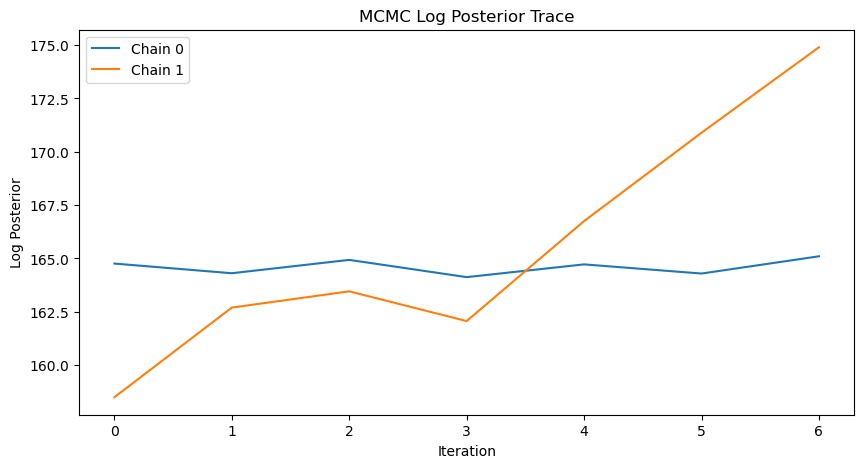

In [15]:
plot_log_posterior(chain_results, burnin_percent, save_path=save_path + f'/log_posterior_burnin_percent={burnin_percent}.png')

In [16]:
print([np.mean(result['acceptsigma']) for result in chain_results if result is not None])

[np.float64(0.6363636363636364), np.float64(0.5454545454545454)]


In [17]:
[np.mean(result['acceptalpha']) for result in chain_results if result is not None]

[np.float64(1.0), np.float64(0.8181818181818182)]

In [18]:
[np.mean(result['acceptpath']) for result in chain_results if result is not None]

[np.float64(0.6363636363636364), np.float64(0.45454545454545453)]

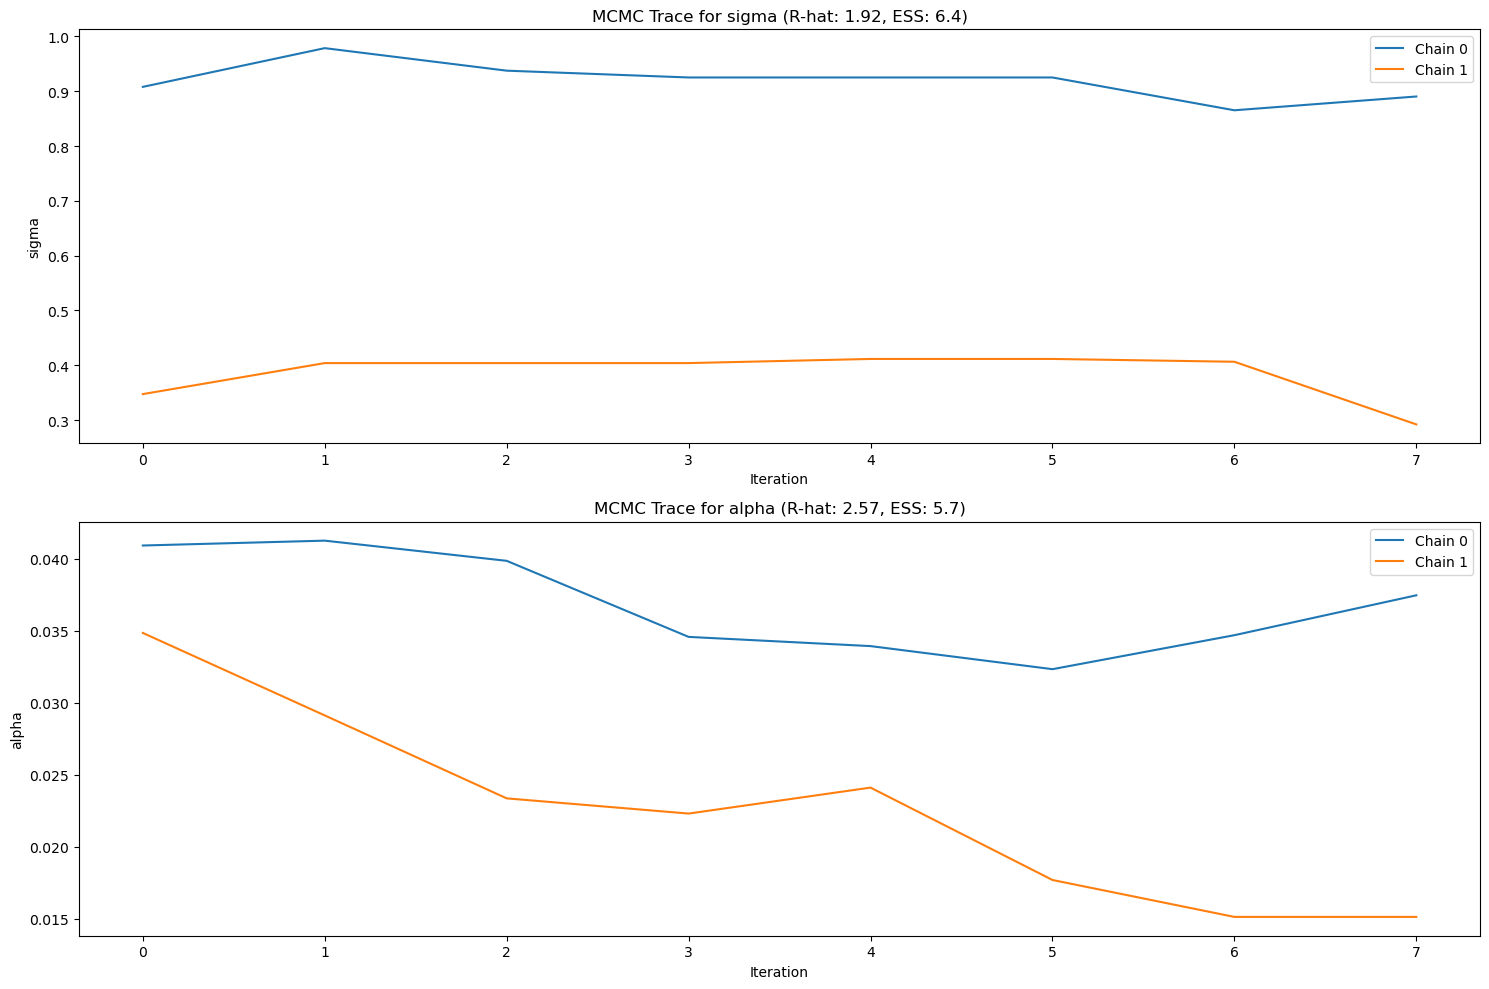

In [19]:
plot_parameter_traces(chain_results, param_names, burnin_percent, savepath=save_path + f'/parameter_traces_burnin_percent={burnin_percent}.png')

In [20]:
burnin_end = int(chain_results[0]['sigma'].shape[0] * burnin_percent)
print(np.mean([chain_results[i]['sigma'][burnin_end:] for i in range(len(chain_results)) if chain_results[i] is not None]))
print(np.mean([chain_results[i]['alpha'][burnin_end:] for i in range(len(chain_results)) if chain_results[i] is not None]))

0.6522534228861332
0.02978673332836479


In [21]:
chain_results[0]['settings']

{'N': 10,
 'dt': 0.05,
 'lambd': 0.95,
 'obs_var': 0.0001,
 'rb': 1.0,
 'seed_mcmc': 80842,
 'prior_sigma_min': 0.0,
 'prior_sigma_max': 1.0,
 'prior_alpha_min': 0.0,
 'prior_alpha_max': 0.05,
 'proposal_sigma_tau': 0.1,
 'proposal_alpha_tau': 0.005,
 'tree_string': '((0:4.1,1:4.1):3.5,(2:5.9,(3:4.2,4:4.2):1.7):1.7);',
 'outputpath': 'exp_2_sigma=0.7_alpha=0.025_dt=0.05/seed=3713700383/mcmc/id=772129937',
 'use_wandb': True,
 'wandb_project': 'SPMS_MCMC'}

In [22]:
diagnostics = compute_diagnostics(chain_results, burnin_percent)

In [23]:
np.mean(chain_results[0]['alpha'])

np.float64(0.03784672001546079)

In [24]:
plot_traces(chain_results, burnin_percent, node_idx=[0, 1, 2, 6], save_path=save_path, diagnostics=diagnostics)

<Figure size 640x480 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

<Figure size 2500x1500 with 0 Axes>

In [25]:
plot_samples_from_posterior(chain_results, burnin_percent=0.5, node_idx=[0, 1, 2, 6], sample_every=50, savepath=save_path, true_values=None)

Node 0: Found 2 samples, shape=(2, 40)
Node 1: Found 2 samples, shape=(2, 40)
Node 2: Found 2 samples, shape=(2, 40)
Node 6: Found 2 samples, shape=(2, 40)
Saved plots to exp_2_sigma=0.7_alpha=0.025_dt=0.05/seed=3713700383/mcmc/id=772129937/plots/samples-posterior-sample_n=50_burnin_percent=0.5.pdf


# Look at posterior covariation

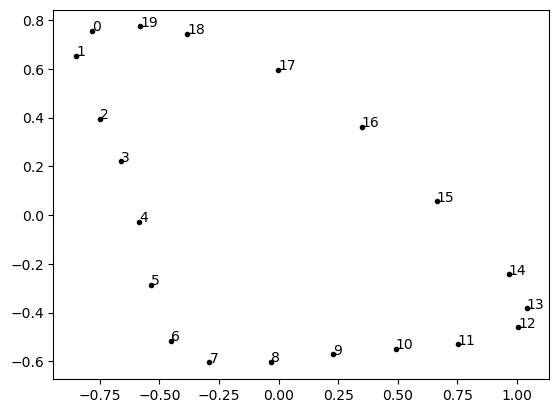

In [26]:
# visualize landmarks with labels 
flat_true_tree = np.genfromtxt(sim_path + "/flat_true_tree.csv", delimiter=',')   
plt.plot(flat_true_tree[0][0::2], flat_true_tree[0][1::2], '.', color='black', linewidth=2, label='true shape')
n = list(range(len(flat_true_tree[0][::2])))
for i, txt in enumerate(n):
    plt.annotate(txt, (flat_true_tree[0][::2][i], flat_true_tree[0][1::2][i]))

In [ ]:
print(list(range(0, 40, 2)))
list(range(1, 40, 2))

In [ ]:
innernode_python = [0, 1, 2, 6]
innernode_R = [6,7,8,9]
node = 3
dim = [0, 2, 22]

# nchain x mcmc iter x nnodes x ndim
burnin_end = int(chain_results[0]['trees'].shape[0] * burnin_percent)
all_posterior_samples = np.array([chain_results[i]['trees'][burnin_end:,:,:] for i in range(len(chain_results)) if chain_results[i] is not None])
print(all_posterior_samples[0].shape)
l0x = all_posterior_samples[:,:,node,dim[0]].flatten()
l1x = all_posterior_samples[:,:,node,dim[1]].flatten()
l12x = all_posterior_samples[:,:,node,dim[2]].flatten()

# load confidence intervals from folder 
conf_dim0 = pd.read_csv(sim_path + f"/fastAnc/95%_conf_trait{dim[0]+1}.csv", header=0, index_col=0)
conf_dim1 = pd.read_csv(sim_path + f"/fastAnc/95%_conf_trait{dim[1]+1}.csv", header=0, index_col=0)
conf_dim2 = pd.read_csv(sim_path + f"/fastAnc/95%_conf_trait{dim[2]+1}.csv", header=0, index_col=0)

In [ ]:
conf_dim0

In [ ]:
def gaussian_kde_contour(x, y, levels=[0.05]):
    
    # Create kernel density estimate
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method="scott")

    # Create a grid to evaluate the KDE
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= 0.1 * x_range
    x_max += 0.1 * x_range
    y_min -= 0.1 * y_range
    y_max += 0.1 * y_range
    x_grid, y_grid = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

    # Evaluate the KDE at the grid positions
    z = kde(positions).reshape(x_grid.shape)

    # Sort density values and find thresholds for specified levels
    z_flat = z.flatten()
    z_sorted = np.sort(z_flat)
    cumsum = np.cumsum(z_sorted)
    cumsum /= cumsum[-1]  # Normalize


    threshold_idx = np.searchsorted(cumsum, levels)
    threshold = z_sorted[threshold_idx]

    return x_grid, y_grid, z, threshold

In [ ]:
import matplotlib.patches as patches
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.15)
axes = axes.flatten()

axes[0].set_xlabel('Landmark 0 (x-coordinate)')
axes[0].set_ylabel('Landmark 1 (x-coordinate)')
axes[0].set_title('Brownian motion model', size=13)
x_min, x_max = conf_dim0.iloc[node, 0], conf_dim0.iloc[node, 1]; y_min, y_max = conf_dim1.iloc[node, 0], conf_dim1.iloc[node, 1]    
padding = 0.8
x_range = x_max - x_min
y_range = y_max - y_min
axes[0].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[0].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=1, 
                         edgecolor='black', 
                         facecolor='steelblue', 
                         alpha=0.5)
axes[0].add_patch(rect)
#axes[0].text(x_max, y_min, "Region of interest", 
#             fontsize=9, 
#             color='black', 
#             va='bottom')
axes[1].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[1].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
axes[1].set_xlabel('Landmark 0 (x-coordinate)')
axes[1].set_ylabel('Landmark 1 (x-coordinate)')
axes[1].set_title('Shape aware model', size=13)
axes[1].plot(l0x, l1x, '.', color='steelblue', alpha=0.1)
x_grid, y_grid, z, threshold = gaussian_kde_contour(l0x, l1x, levels=[0.05])
contour = axes[1].contour(x_grid, y_grid, z, levels=[threshold], 
                         colors='black', linewidths=1)
#axes[1].clabel(contour, inline=True, fontsize=10, fmt='%.2f')

padding=0.8
axes[2].set_xlabel('Landmark 0 (x-coordinate)')
axes[2].set_ylabel('Landmark 12 (x-coordinate)')
x_min, x_max = conf_dim0.iloc[node, 0], conf_dim0.iloc[node, 1]; y_min, y_max = conf_dim2.iloc[node, 0], conf_dim2.iloc[node, 1]
axes[2].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[2].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=1, 
                         edgecolor='black', 
                         facecolor='steelblue', 
                         alpha=.5)
axes[2].add_patch(rect)
axes[3].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[3].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
axes[3].set_xlabel('Landmark 0 (x-coordinate)')
axes[3].set_ylabel('Landmark 12 (x-coordinate)')
axes[3].plot(l0x, l12x, '.', color='steelblue', alpha=0.1)
x_grid, y_grid, z, threshold = gaussian_kde_contour(l0x, l12x, levels=[0.05])
contour = axes[3].contour(x_grid, y_grid, z, levels=[threshold], 
                         colors='black', linewidths=1)
plt.savefig(save_path+"/posterior_covariation.pdf")